In [1]:
import pandas as pd
import numpy as np 
import pickle5
import matplotlib.pyplot as plt
import datetime
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.display import display_loss_values
from sklearn.preprocessing import StandardScaler
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils import save_model, load_model
from pysurvival.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, r2_score
from pysurvival.utils.metrics import concordance_index

In [2]:
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head(3)

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


In [3]:
df.shape

(12711, 71)

### Remove events

In [4]:
names = df['Station_Name'].unique()

In [5]:
for name in names:
    temp = df[df['Station_Name'] == name]
    rows = temp[temp['lag3'].isna()]
    if rows.life_time.sum() < 3*60:
        print("The station has the lagged")
        print(name)

# remove rows
df = df.dropna()

The station has the lagged
BOULDER / REC CENTER
The station has the lagged
BOULDER / ATRIUM ST1
The station has the lagged
BOULDER / ALPINE ST1
The station has the lagged
COMM VITALITY / 1400 WALNUT1
The station has the lagged
BOULDER / FACILITIES ST1
The station has the lagged
COMM VITALITY / 1500PEARL
The station has the lagged
BOULDER / JUNCTION ST1
The station has the lagged
COMM VITALITY / BOULDER JCTN
The station has the lagged
COMM VITALITY / 1100WALNUT1
The station has the lagged
BOULDER / BOULDER PARK
The station has the lagged
COMM VITALITY / 2200 BROADWAY1
The station has the lagged
BOULDER / EAST REC
The station has the lagged
BOULDERJUNCTION / JUNCTION ST1


In [6]:
df.shape

(12699, 71)

### Remove outliers
Use boxplot outlier definition

In [7]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [8]:
df.shape

(12075, 71)

### Focus stations

In [9]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']

df = df[df['Station_Name'].isin(station_subset)]

### Prepare data for SA

As we are doing SA we need a column which specifies if an event occured at the given time. As all data observations in the dataset are events it is a very simple procedure

In [10]:
df['event'] = np.ones(len(df))

In [11]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [12]:
df['tod'] = df['hour_b'].apply(hour_label)

In [13]:
df = df[df['tod'] != 'Night']

### Adding dummies
We define `X`, the features, `T`, the time column and `E` the event columns. First though we need to dummify the categorical variables.

In [14]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','hour_b','Station_Name']

In [15]:
df_orig = df
df = pd.get_dummies(df, columns=columns_categorical, drop_first=True)

## Modeling features

To make coding easier the names of the models are changed:
- M1: Baseline
- M5: Full

In [16]:
time_column = 'life_time'
event_column = 'event'

## M1
features1 = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
             'tod_Evening','tod_Midday', 'tod_Morning',
             'Station_Name_BOULDER / N BOULDER REC 1',
             'Station_Name_COMM VITALITY / 1000WALNUT',
             'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + tod

## M5
features5_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features5_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education', 'waste-management'] # dow + agg. tod + lag + activ.

In [17]:
# dictionary to save results in 
results = {}

#data split
split = 0.8

# order data
df = df.sort_values(by=['datetime_start'])
df = df.reset_index(drop=True)
df_orig = df_orig.sort_values(by=['datetime_start'])
df_orig = df_orig.reset_index(drop=True)

#### CPH - Full

In [18]:
# define data
X = df[features5_cat + features5_con]

X_train, X_test = np.split(X, [int(split * len(df))])
T_train, T_test = np.split(df[time_column], [int(split * len(df))])
E_train, E_test = np.split(df[event_column], [int(split * len(df))])

scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.transform(X_test[features5_con])


### Get predictions
reg = CoxPHModel()
reg.fit(X_train, T_train, E_train, lr=0.01, l2_reg=0.01,
        init_method='zeros', max_iter=800, verbose=False)
print("Model fitted")   

surv = reg.predict_survival(x=X_test)
haza = reg.predict_hazard(x=X_test)

Model fitted


In [19]:
coef_df = pd.DataFrame(columns=(['feature','coefficients']))
coef_df['feature'] = X_test.columns
coef_df['coefficients'] = reg.weights
coef_df = coef_df.sort_values(by=['coefficients'])

In [20]:
coef_df.head(5)

,feature,coefficients
6,tod_Evening,-0.147311
23,medical,-0.115711
13,lag2,-0.082482
2,weekday_b_name_Sunday,-0.065069
0,weekday_b_name_Monday,-0.053225


In [21]:
coef_df.tail(5)

,feature,coefficients
10,Station_Name_COMM VITALITY / 1000WALNUT,0.049323
19,service,0.069089
9,Station_Name_BOULDER / N BOULDER REC 1,0.086594
8,tod_Morning,0.158344
7,tod_Midday,0.159898


In [23]:
time = reg.times

In [24]:
new_col = ['tod','weekday_b_name','Station_Name'] 
X_test = X_test.merge(df_orig[new_col], left_index=True, right_index=True)
X_test = X_test.reset_index()

#### Survival curves for TOD, seperate curves for each station

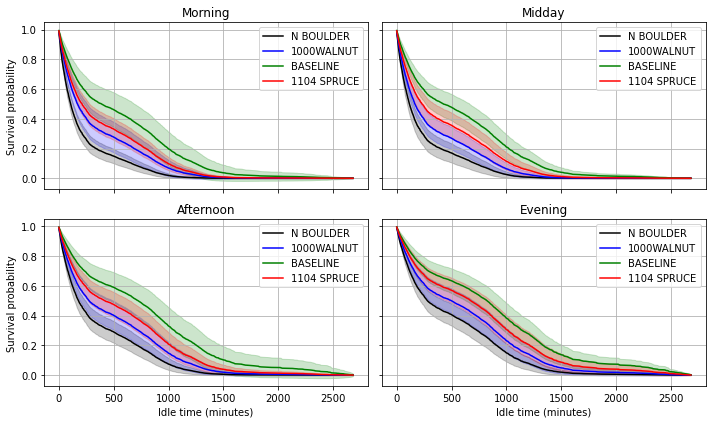

In [25]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tods = ['Morning', 'Midday', 'Afternoon', 'Evening']#, 'Night']

fig, axs = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)
i = 0
j = 0

temp1 = X_test[X_test['Station_Name'] == 'BOULDER / N BOULDER REC 1']
temp2 = X_test[X_test['Station_Name'] == 'COMM VITALITY / 1000WALNUT']
temp3 = X_test[X_test['Station_Name'] == 'BOULDER / BASELINE ST1']
temp4 = X_test[X_test['Station_Name'] == 'COMM VITALITY / 1104 SPRUCE1']

N = 2

for tod in tods:
    idx1 = temp1[(temp1['tod'] == tod)].index
    temp_surv1 = surv[idx1]
    mean1 = []
    upper1 = []
    lower1 = []

    idx2 = temp2[(temp2['tod'] == tod)].index
    temp_surv2 = surv[idx2]
    mean2 = []
    upper2 = []
    lower2 = []
    
    idx3 = temp3[(temp3['tod'] == tod)].index
    temp_surv3 = surv[idx3]
    mean3 = []
    upper3 = []
    lower3 = []
    
    idx4 = temp4[(temp4['tod'] == tod)].index
    temp_surv4 = surv[idx4]
    mean4 = []
    upper4 = []
    lower4 = []

    for k in range(len(time)):
        ## REC 1
        vals1 = temp_surv1[:,k]
        mean1.append(np.mean(vals1))
        std1 = np.std(vals1)
        upper1.append(np.mean(vals1)+std1*N)
        lower1.append(np.mean(vals1)-std1*N)
        ## 1000WALNUT
        vals2 = temp_surv2[:,k]
        mean2.append(np.mean(vals2))
        std2 = np.std(vals2)
        upper2.append(np.mean(vals2)+std2*N)
        lower2.append(np.mean(vals2)-std2*N)
        ## BASELINE ST1
        vals3 = temp_surv3[:,k]
        mean3.append(np.mean(vals3))
        std3 = np.std(vals3)
        upper3.append(np.mean(vals3)+std3*N)
        lower3.append(np.mean(vals3)-std3*N)
        ## 1104 SPRUCE1
        vals4 = temp_surv4[:,k]
        mean4.append(np.mean(vals4))
        std4 = np.std(vals4)
        upper4.append(np.mean(vals4)+std4*N)
        lower4.append(np.mean(vals4)-std4*N)
        
    axs[i,j].grid()
    axs[i,j].fill_between(x=time,y1=lower1,y2=upper1, alpha=0.2, color='k')
    axs[i,j].plot(time,mean1, label='N BOULDER', color='k')
    
    axs[i,j].fill_between(x=time,y1=lower2,y2=upper2, alpha=0.2, color='b')
    axs[i,j].plot(time,mean2, label='1000WALNUT', color='b')
    
    axs[i,j].fill_between(x=time,y1=lower3,y2=upper3, alpha=0.2, color='g')
    axs[i,j].plot(time,mean3, label='BASELINE', color='g')
    
    axs[i,j].fill_between(x=time,y1=lower4,y2=upper4, alpha=0.2, color='r')
    axs[i,j].plot(time,mean4, label='1104 SPRUCE', color='r')
    
    axs[i,j].set_title("{}".format(tod))
    axs[i,j].legend()

    j += 1
    if j == 2:
        j = 0
        i = 1

axs[1,0].set_xlabel("Idle time (minutes)")
axs[1,1].set_xlabel("Idle time (minutes)")
axs[0,0].set_ylabel("Survival probability")
axs[1,0].set_ylabel("Survival probability")
plt.tight_layout()
plt.savefig('../visualization/SA_TOD_singleStep.pdf',bbox_inches='tight')
plt.show()

#### Without TOD seperated data

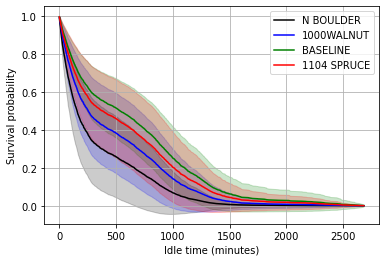

In [27]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tods = ['Morning', 'Midday', 'Afternoon', 'Evening']#, 'Night']

temp1 = X_test[X_test['Station_Name'] == 'BOULDER / N BOULDER REC 1']
temp2 = X_test[X_test['Station_Name'] == 'COMM VITALITY / 1000WALNUT']
temp3 = X_test[X_test['Station_Name'] == 'BOULDER / BASELINE ST1']
temp4 = X_test[X_test['Station_Name'] == 'COMM VITALITY / 1104 SPRUCE1']

N = 2

mean1 = []
upper1 = []
lower1 = []
mean2 = []
upper2 = []
lower2 = []
mean3 = []
upper3 = []
lower3 = []
mean4 = []
upper4 = []
lower4 = []

surv1 = surv[temp1.index]
surv2 = surv[temp2.index]
surv3 = surv[temp3.index]
surv4 = surv[temp4.index]

for k in range(len(time)):
    ## REC 1
    vals1 = surv1[:,k]
    mean1.append(np.mean(vals1))
    std1 = np.std(vals1)
    upper1.append(np.mean(vals1)+std1*N)
    lower1.append(np.mean(vals1)-std1*N)
    ## 1000WALNUT
    vals2 = surv2[:,k]
    mean2.append(np.mean(vals2))
    std2 = np.std(vals2)
    upper2.append(np.mean(vals2)+std2*N)
    lower2.append(np.mean(vals2)-std2*N)
    ## BASELINE ST1
    vals3 = surv3[:,k]
    mean3.append(np.mean(vals3))
    std3 = np.std(vals3)
    upper3.append(np.mean(vals3)+std3*N)
    lower3.append(np.mean(vals3)-std3*N)
    ## 1104 SPRUCE1
    vals4 = surv4[:,k]
    mean4.append(np.mean(vals4))
    std4 = np.std(vals4)
    upper4.append(np.mean(vals4)+std4*N)
    lower4.append(np.mean(vals4)-std4*N)
    
# plot
plt.fill_between(x=time,y1=lower1,y2=upper1, alpha=0.2, color='k')
plt.plot(time,mean1, label='N BOULDER', color='k')

plt.fill_between(x=time,y1=lower2,y2=upper2, alpha=0.2, color='b')
plt.plot(time,mean2, label='1000WALNUT', color='b')

plt.fill_between(x=time,y1=lower3,y2=upper3, alpha=0.2, color='g')
plt.plot(time,mean3, label='BASELINE', color='g')

plt.fill_between(x=time,y1=lower4,y2=upper4, alpha=0.2, color='r')
plt.plot(time,mean4, label='1104 SPRUCE', color='r')
plt.legend()

#plt.title("Short (<4H)")
plt.grid()
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
# plt.tight_layout()
plt.savefig('../visualization/SA_singleStep.pdf',bbox_inches='tight')
plt.show()

### Get table

In [29]:
hour_steps = [0.5*60,1*60,2*60,4*60,8*60]
hour_steps_idx = []
for hour in hour_steps:
    #print(hour)
    temp = []
    for i in range(len(time)):
        if (time[i] >= hour) and (time[i] < hour+2):
            #print("{}H".format(hour/60))
            #print(i,time[i])
            temp.append(i)
    if len(temp) > 1:
        hour_steps_idx.append(int(np.float_(temp[0])))
    else:
        hour_steps_idx.append(temp)


In [30]:
hour_steps_idx

[30, 60, 120, 238, [432]]

In [31]:
hour_steps_idx = [30, 60, 120, 238, 433]

In [32]:
for t in tods:
    print(10*'-',t,10*'-')
    for stat in station_subset:
        temp = X_test[(X_test['tod'] == t) & (X_test['Station_Name'] == stat)]
        temp_surv = surv[temp.index]
        print(stat)
        for i in range(len(hour_steps)):
            h_surv = temp_surv[:,hour_steps_idx[i]]
            m = round(np.mean(h_surv),2)
            std = round(np.std(h_surv),2)*2
            print("{} ({}): mean: {}  std: {}".format(hour_steps[i]/60,hour_steps[i],m,std))
    print("\n")

---------- Morning ----------
BOULDER / N BOULDER REC 1
0.5 (30.0): mean: 0.79  std: 0.04
1.0 (60): mean: 0.66  std: 0.04
2.0 (120): mean: 0.46  std: 0.06
4.0 (240): mean: 0.27  std: 0.06
8.0 (480): mean: 0.15  std: 0.04
COMM VITALITY / 1000WALNUT
0.5 (30.0): mean: 0.85  std: 0.04
1.0 (60): mean: 0.75  std: 0.06
2.0 (120): mean: 0.59  std: 0.08
4.0 (240): mean: 0.41  std: 0.1
8.0 (480): mean: 0.28  std: 0.1
COMM VITALITY / 1104 SPRUCE1
0.5 (30.0): mean: 0.87  std: 0.02
1.0 (60): mean: 0.78  std: 0.04
2.0 (120): mean: 0.64  std: 0.06
4.0 (240): mean: 0.47  std: 0.08
8.0 (480): mean: 0.34  std: 0.08
BOULDER / BASELINE ST1
0.5 (30.0): mean: 0.91  std: 0.02
1.0 (60): mean: 0.84  std: 0.04
2.0 (120): mean: 0.73  std: 0.08
4.0 (240): mean: 0.59  std: 0.1
8.0 (480): mean: 0.47  std: 0.12


---------- Midday ----------
BOULDER / N BOULDER REC 1
0.5 (30.0): mean: 0.8  std: 0.04
1.0 (60): mean: 0.68  std: 0.06
2.0 (120): mean: 0.49  std: 0.08
4.0 (240): mean: 0.3  std: 0.08
8.0 (480): mean: 0.17